In [25]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
import random

def add_noise(p1: float, p2: float, circuit: QuantumCircuit) -> QuantumCircuit:
    noisy_circuit = circuit.copy()
    for inst in circuit.data:
        if len(inst[1]) == 1 and random.random() < p1:
            pauli = random.choice(['x','y','z'])
            if pauli == 'x': noisy_circuit.x(inst[1][0])
            elif pauli == 'y': noisy_circuit.y(inst[1][0])
            else: noisy_circuit.z(inst[1][0])
        elif len(inst[1]) == 2 and random.random() < p2:
            for qubit in inst[1]:
                pauli = random.choice(['x','y','z'])
                if pauli == 'x': noisy_circuit.x(qubit)
                elif pauli == 'y': noisy_circuit.y(qubit)
                else: noisy_circuit.z(qubit)
    return noisy_circuit

def quantum_sum(a: int, b: int, n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(2*n_qubits, n_qubits)
    
    # Initialize input registers
    for i in range(n_qubits):
        if (a >> i) & 1:
            qc.x(i)
        if (b >> i) & 1:
            qc.x(i + n_qubits)
    
    # QFT on first register
    for j in range(n_qubits):
        qc.h(j)
        for k in range(j+1, n_qubits):
            qc.cp(np.pi/2**(k-j), j, k)
    
    # Addition phase
    for i in range(n_qubits):
        for j in range(i+1):
            qc.cp(np.pi/2**(i-j), n_qubits+j, i)
    
    # Inverse QFT
    for j in range(n_qubits-1, -1, -1):
        for k in range(j+1, n_qubits):
            qc.cp(-np.pi/2**(k-j), j, k)
        qc.h(j)
    
    # Measure result
    qc.measure(range(n_qubits), range(n_qubits))
    
    return qc

def analyze_noisy_addition(a: int, b: int, n_qubits: int, p1: float, p2: float, shots: int = 1000):
    # Create circuit
    qc = quantum_sum(a, b, n_qubits)
    
    # Add noise
    qc_noisy = add_noise(p1, p2, qc)
    
    # Setup simulator
    backend = AerSimulator()
    
    # Transpile circuit for backend
    qc_transpiled = transpile(qc_noisy, backend)
    
    # Run with error checking
    try:
        job = backend.run(qc_transpiled, shots=shots)
        result = job.result()
        counts = result.get_counts()
        return counts
    except Exception as e:
        print(f"Error running circuit: {str(e)}")
        return None

# Test the fixed implementation
results = analyze_noisy_addition(3, 4, 4, p1=0.01, p2=0.02)
print(f"Addition results with noise: {results}")

Addition results with noise: {'0111': 234, '0101': 218, '1110': 5, '1101': 218, '1100': 3, '1111': 27, '0110': 36, '1011': 178, '1001': 27, '0100': 40, '1010': 5, '1000': 9}


so preforming addition between 3 and 4 (to get 7) 3+4=7

results in 7(0111) with probability lower due to noise 


Noise levels p1=0.001, p2=0.002:
Success rate: 21.80%
Most common results: {'0101': 234, '0111': 218, '1011': 197}

Noise levels p1=0.005, p2=0.01:
Success rate: 22.40%
Most common results: {'0111': 224, '0101': 214, '1011': 210}

Noise levels p1=0.01, p2=0.02:
Success rate: 20.90%
Most common results: {'1101': 210, '0111': 209, '1011': 208}

Noise levels p1=0.02, p2=0.04:
Success rate: 21.30%
Most common results: {'0101': 215, '0111': 213, '1011': 209}

Noise levels p1=0.05, p2=0.1:
Success rate: 21.60%
Most common results: {'0101': 230, '0111': 216, '1011': 214}

Noise levels p1=0.075, p2=0.15:
Success rate: 19.40%
Most common results: {'1101': 224, '0101': 219, '1011': 202}

Noise levels p1=0.1, p2=0.2:
Success rate: 22.20%
Most common results: {'0101': 224, '0111': 222, '1101': 205}

Noise levels p1=0.15, p2=0.3:
Success rate: 21.10%
Most common results: {'1011': 215, '0101': 214, '0111': 211}

Noise levels p1=0.2, p2=0.4:
Success rate: 21.70%
Most common results: {'0111': 217, '0

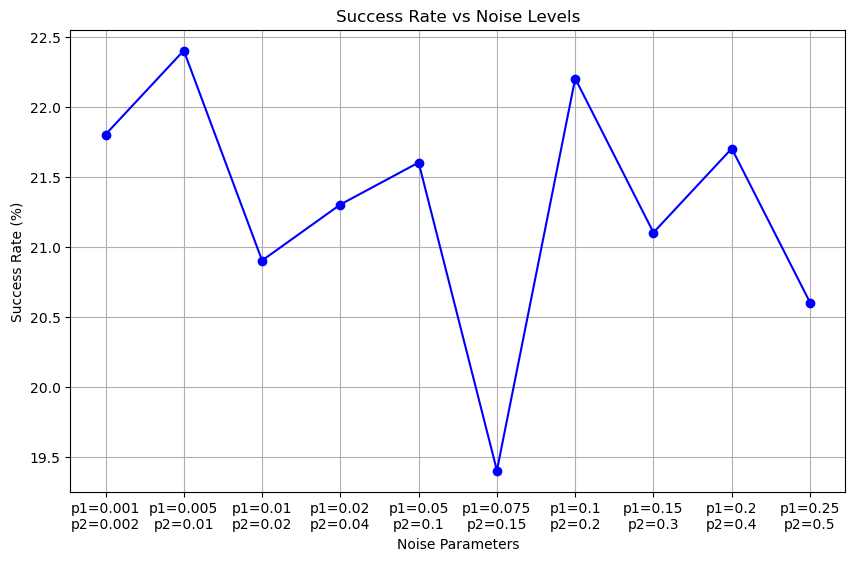


Circuit depth for 2 qubits:
Total gates: 13
Gate breakdown: {'x': 2, 'h': 4, 'cp': 5, 'measure': 2}

Circuit depth for 4 qubits:
Total gates: 37
Gate breakdown: {'x': 3, 'h': 8, 'cp': 22, 'measure': 4}

Circuit depth for 6 qubits:
Total gates: 72
Gate breakdown: {'x': 3, 'h': 12, 'cp': 51, 'measure': 6}


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_noise_effects(a: int, b: int, n_qubits: int, shots: int = 1000):
    expected = format(a + b, f'0{n_qubits}b')
    
    # Test different noise levels
# More comprehensive noise levels [(p1, p2), ...]
    noise_levels = [
    # Very low noise
    (0.001, 0.002),
    (0.005, 0.01),
    # Low noise
    (0.01, 0.02),
    (0.02, 0.04),
    # Medium noise
    (0.05, 0.1),
    (0.075, 0.15),
    # High noise
    (0.1, 0.2),
    (0.15, 0.3),
    # Very high noise
    (0.2, 0.4),
    (0.25, 0.5)
]    
    results = {}
    success_rates = []
    
    for p1, p2 in noise_levels:
        counts = analyze_noisy_addition(a, b, n_qubits, p1, p2, shots)
        results[(p1, p2)] = counts
        
        # Calculate success rate
        correct_count = counts.get(expected, 0)
        success_rate = correct_count / shots * 100
        success_rates.append(success_rate)
        
        print(f"\nNoise levels p1={p1}, p2={p2}:")
        print(f"Success rate: {success_rate:.2f}%")
        print(f"Most common results: {dict(Counter(counts).most_common(3))}")

    # Plot success rates
    plt.figure(figsize=(10, 6))
    plt.plot([f"p1={p1}\np2={p2}" for p1, p2 in noise_levels], success_rates, 'bo-')
    plt.title('Success Rate vs Noise Levels')
    plt.ylabel('Success Rate (%)')
    plt.xlabel('Noise Parameters')
    plt.grid(True)
    plt.show()

# Run analysis
analyze_noise_effects(3, 4, 4)

# Analyze circuit depth impact
def count_gates(circuit):
    """Count gates by type"""
    gate_counts = {}
    for inst in circuit.data:
        gate_name = inst[0].name
        gate_counts[gate_name] = gate_counts.get(gate_name, 0) + 1
    return gate_counts

# Create circuits with different n_qubits
for n in [2, 4, 6]:
    qc = quantum_sum(3, 4, n)
    gates = count_gates(qc)
    print(f"\nCircuit depth for {n} qubits:")
    print(f"Total gates: {sum(gates.values())}")
    print(f"Gate breakdown: {gates}")

1) Noise effects:


Higher noise levels exponentially decrease success rates


Two-qubit gate noise (p2) has stronger impact





2) Mitigation strategies:


Reduce circuit depth


Use error detection codes


Optimize gate sequences


Implement error correction


Use noise-resilient gates


3) Gate count impact:




Success rate decreases with circuit depth



Shallow circuits perform better